In [1]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

# Pre-training results


In [2]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import pandas as pd
import toml
import os
import glob
import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# from presentation.pipelines.steps.load_data import build_loader
# from presentation.pipelines.steps.model_design import load_pt_model

from src.utils import tensorboard_logs

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

2025-01-28 07:55:08.182946: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-28 07:55:08.182990: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-28 07:55:08.183020: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 07:55:08.190911: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
TAG = 'diagstromer' # should match the name of the hyperparameter in config.toml 
model_paths = glob.glob(os.path.join('./presentation/results/{}/'.format(TAG), '*', 'pretraining'))
# model_paths = [model_paths[0]]

In [72]:
sorted_path = np.array(model_paths.copy())
index_value = []
for path in sorted_path:
    with open(os.path.join(path, 'config.toml'), 'r') as file:
        conf = toml.load(file)
        if TAG == 'diagstromer':
            if 'bigmacho' in conf['data']:
                label = 'A2x'
            else:
                label = 'A2'
                
        if TAG == 'temperature':
            label = r'$\tau$={:.2f}'.format(train_metrics['temperature'].iloc[0])
            
        if TAG == 'm_alpha':
            val = train_metrics['m_alpha'].iloc[0]
            if float(val) == -1e9:
                label = r'$\alpha$=$-\infty$'
            else:
                label = r'$\alpha$={:.0f}'.format(val)
        index_value.append(label)
        
index_value    = np.array(index_value)
sorted_indices = np.argsort(index_value)
sorted_path    = list(sorted_path[sorted_indices])
sorted_labels  = list(index_value[sorted_indices])

del sorted_labels[-1]
del sorted_path[-1]
sorted_labels, sorted_path

(['A2', 'A2x'],
 ['./presentation/results/diagstromer/2024-12-02_14-13-12/pretraining',
  './presentation/results/diagstromer/2024-12-04_09-14-06/pretraining'])

## Learning curves

In [73]:
train_metrics, validation_metrics = [], []
for k, path in enumerate(sorted_path):
    tmr, vmr = tensorboard_logs(path)
    train_metrics.append(tmr)
    validation_metrics.append(vmr)

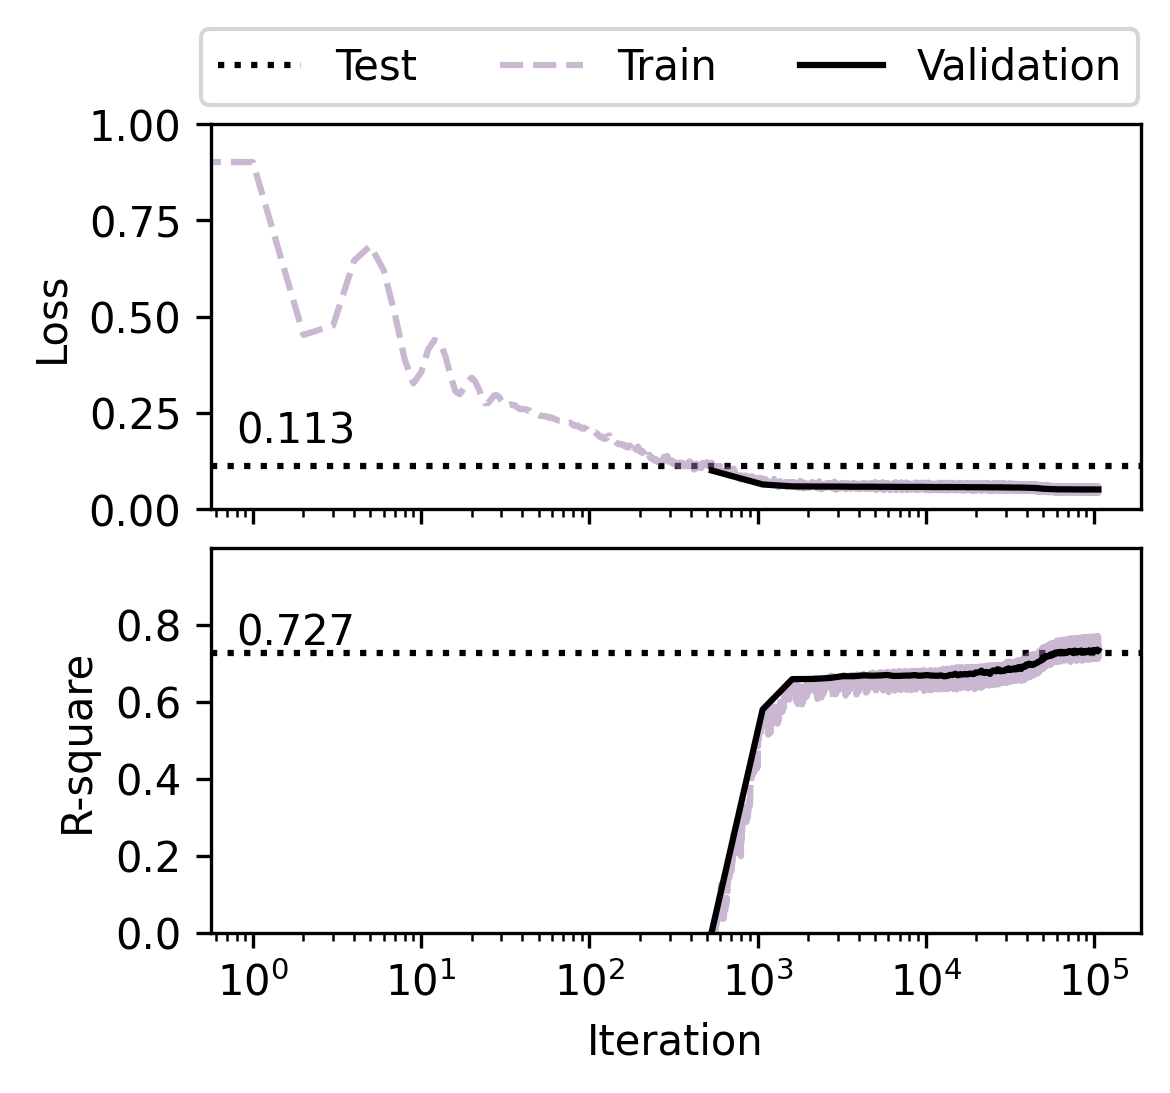

In [74]:
fig, axes = plt.subplots(2, 1, figsize=(4, 3.5), dpi=300, sharex=True, gridspec_kw={'wspace':0.2, 'hspace':0.1})
colormap = ['k', 'gray', 'b', 'g', 'y']
for k, path in enumerate(sorted_path[:1]):
    try:
        curr = os.path.join(path, 'results.csv')
        partial_df = pd.read_csv(curr)
        axes[1].axhline(y=partial_df['test_r2'].values[0], color='k', linestyle=':', label='Test'.format(sorted_labels[k]))
        axes[0].axhline(y=partial_df['test_mse'].values[0], color='k', linestyle=':', label='Test'.format(sorted_labels[k]))
        axes[0].text(0.8, partial_df['test_mse'].values[0]+0.06, '{:.3f}'.format(partial_df['test_mse'].values[0]), color='k')
        axes[1].text(0.8, partial_df['test_r2'].values[0]+0.02, '{:.3f}'.format(partial_df['test_r2'].values[0]), color='k')
    except Exception as e:
        print(e)
        pass
        
    if 'loss' not in validation_metrics[k].columns:
        validation_metrics[k]['loss'] = validation_metrics[k]['rmse']

    axes[0].plot(train_metrics[k]['step'].values, train_metrics[k]['loss'].values, 
                 label='Train'.format(sorted_labels[k]), color='#9673A6', linestyle='--', alpha=0.5)
    axes[0].plot(validation_metrics[k]['step'].values, validation_metrics[k]['loss'].values, 
                 label='Validation'.format(sorted_labels[k]), color=colormap[k])
    
    axes[1].plot(train_metrics[k]['step'].values, train_metrics[k]['rsquare'].values, 
                 label='Train'.format(sorted_labels[k]), color="#9673A6", linestyle='--', alpha=0.5)
    axes[1].plot(validation_metrics[k]['step'].values, validation_metrics[k]['rsquare'].values, 
                 label='Validation'.format(sorted_labels[k]), color=colormap[k])    
    
    axes[1].set_yticks([0, 0.2, 0.4, 0.6, 0.8])
    
    axes[0].legend(bbox_to_anchor=(1.02, 1.3), ncol=3)
    # axes[1].legend()#bbox_to_anchor=(1., 1.0)
    
    axes[0].set_ylabel('Loss')
    axes[0].set_xscale('log')
    axes[1].set_xscale('log')
    # axes[0].set_xlabel('Iteration')
    axes[1].set_xlabel('Iteration')
    
    axes[1].set_ylabel('R-square')
    axes[1].set_ylim(0., 1)
    axes[0].set_ylim(0., 1)
    
    

# fig.title('Learning curves on Validation')
fig.savefig('./presentation/figures/tr_astromer_2.pdf', format='pdf',  bbox_inches='tight')  
plt.show()

### Validation & Testing

In [75]:
y1_plot, y2_plot = [], []
for k, logs in enumerate(sorted_path):
    
    row = validation_metrics[k][validation_metrics[k]['rmse'].astype('float').values == validation_metrics[k]['rmse'].min()]
    y1_plot.append(float(row['rmse'].values[0]))
    if 'rsquare' not in validation_metrics[k].columns:
        y2_plot.append(0.8)
    else:
        y2_plot.append(float(row['rsquare'].values[0]))

In [76]:
x_plot  = np.array(sorted_labels)
y1_plot = np.array(y1_plot)
y2_plot = np.array(y2_plot)
test_metrics_pt = []
for i, path in enumerate(sorted_path):
    curr = os.path.join(path, 'results.csv')
    try:
        partial_df = pd.read_csv(curr)
    except:
        partial_df = pd.DataFrame({'test_mse': [0.], 'test_r2': [0.]})
        
    partial_df[TAG] = x_plot[i]        
    test_metrics_pt.append(partial_df)

test_metrics_pt = pd.concat(test_metrics_pt)  

In [77]:
df = pd.DataFrame()
df[TAG] = x_plot
df['val_rmse'] = y1_plot
df['val_r2'] = y2_plot
df_1 = test_metrics_pt[[TAG, 'test_mse', 'test_r2']]
df_2 = pd.merge(df, df_1, on=TAG)
df_2 = df_2.round(3)
df_2

,diagstromer,val_rmse,val_r2,test_mse,test_r2
0,A2,0.051,0.732,0.113,0.727
1,A2x,0.052,0.732,0.000,0.000


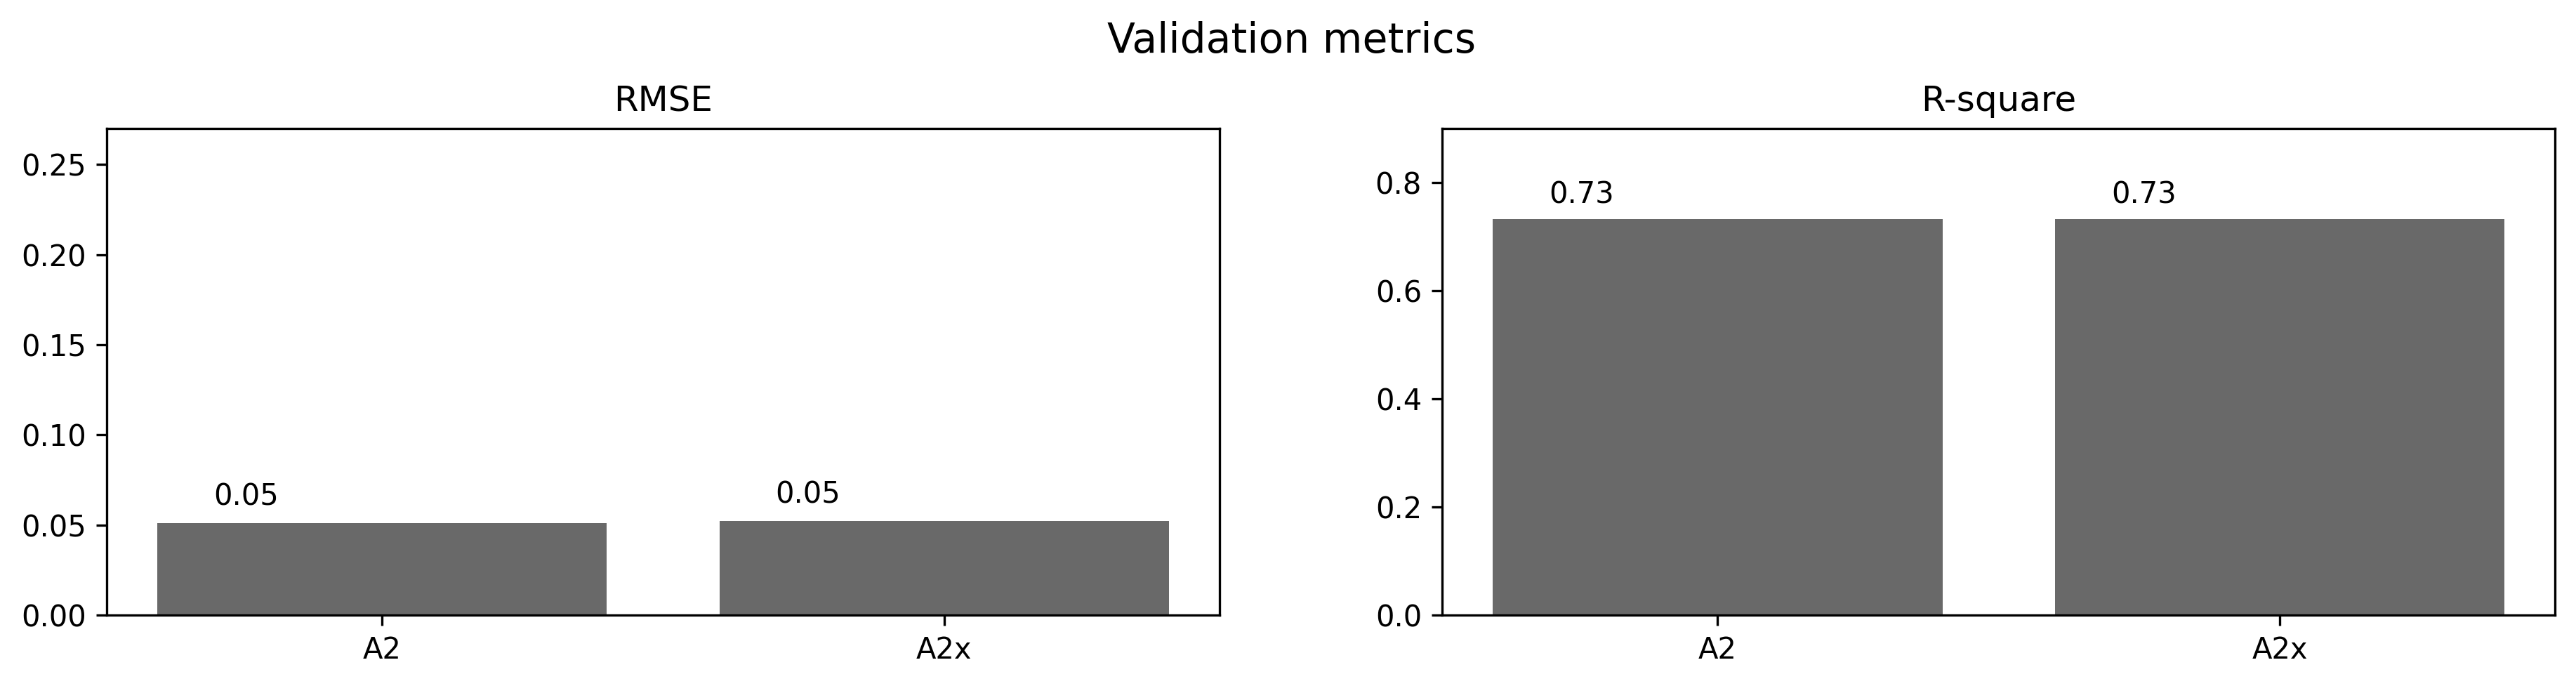

In [78]:
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(15, 3))

xticks = range(len(x_plot))
axes[0].bar(xticks, y1_plot, color='dimgray')
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(x_plot, rotation=0)
axes[0].set_title('RMSE')
axes[0].set_ylim(0, 0.27)


for i, value in enumerate(y1_plot):
    axes[0].text(i-.3, value+0.01, '{:.2f}'.format(value))

axes[1].bar(xticks, y2_plot, color='dimgray')
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(x_plot, rotation=0)
for i, value in enumerate(y2_plot):
    if i < 2 and TAG == 'n_samples':
        axes[1].text(i-.3, 0.03, '{:.2f}'.format(value))
    else:
        axes[1].text(i-.3, value+0.03, '{:.2f}'.format(value))

axes[1].set_title('R-square')
if TAG == 'n_samples':
    axes[1].set_ylim(-0.1, 0.90)
else:
    axes[1].set_ylim(-0., 0.90)

fig.text(0.5, 1., 'Validation metrics', ha='center', fontsize=14)
if TAG == 'temperature':
    fig.text(0.5, -0.03, r'Temperature ($\tau$)', ha='center', fontsize=12)
if TAG == 'm_alpha':
    fig.text(0.5, -0.03, r'Soft-masking scaling term ($\alpha$)', ha='center', fontsize=12)
if TAG == 'n_samples':
    fig.text(0.5, -0.03, r'Number of pretraining samples', ha='center', fontsize=12)
if TAG == 'ckpt':
    fig.text(0.5, -0.03, r'Checkpoint epoch', ha='center', fontsize=12)
if TAG == 'best_0_to_1':
    fig.text(0.5, -0.03, r'New architecture feature', ha='center', fontsize=12)

os.makedirs('./presentation/figures/htune/{}'.format(TAG), exist_ok=True)
fig.savefig('./presentation/figures/htune/{}/val.pdf'.format(TAG), format='pdf', bbox_inches='tight')  
plt.show()

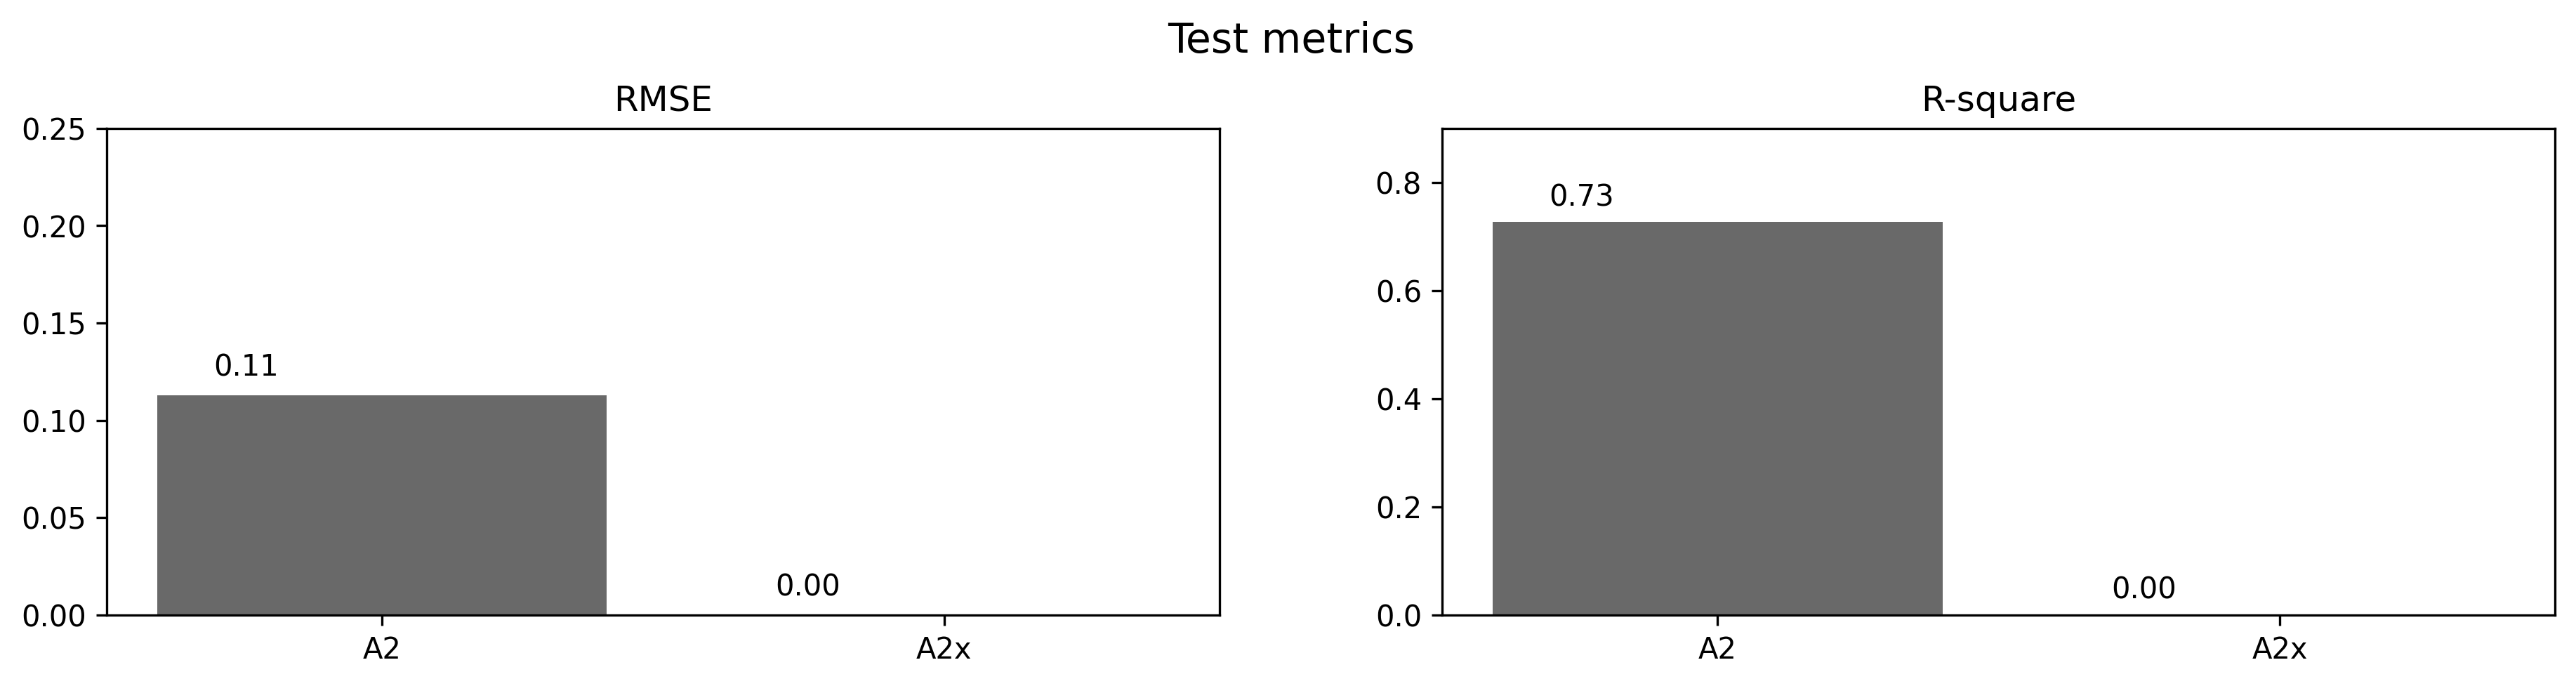

In [79]:
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(15, 3))

axes[0].bar(xticks, test_metrics_pt['test_mse'], color='dimgray')
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(x_plot, rotation=0)
axes[0].set_title('RMSE')
axes[0].set_ylim(0, 0.25)

for i, value in enumerate(test_metrics_pt['test_mse']):
    axes[0].text(i-.3, value+0.01, '{:.2f}'.format(value))

axes[1].bar(xticks, test_metrics_pt['test_r2'], color='dimgray')
axes[1].set_xticks(xticks)

axes[1].set_xticklabels(x_plot, rotation=0)

for i, value in enumerate(test_metrics_pt['test_r2']):
    if i < 2 and TAG == 'n_samples':
        axes[1].text(i-.3, 0.03, '{:.2f}'.format(value))
    else:
        axes[1].text(i-.3, value+0.03, '{:.2f}'.format(value))
    
axes[1].set_title('R-square')
if TAG == 'n_samples':
    axes[1].set_ylim(-0.1, 0.87)
else:
    axes[1].set_ylim(-0., 0.90)

fig.text(0.5, 1., 'Test metrics', ha='center', fontsize=14)
if TAG == 'temperature':
    fig.text(0.5, -0.03, r'Temperature ($\tau$)', ha='center', fontsize=12)
if TAG == 'm_alpha':
    fig.text(0.5, -0.03, r'Soft-masking scaling term ($\alpha$)', ha='center', fontsize=12)
if TAG == 'n_samples':
    fig.text(0.5, -0.03, r'Number of pretraining samples', ha='center', fontsize=12)
if TAG == 'best_0_to_1':
    fig.text(0.5, -0.03, r'New architecture feature', ha='center', fontsize=12)
    
fig.savefig('./presentation/figures/htune/{}/test.pdf'.format(TAG), format='pdf', bbox_inches='tight')  
plt.show() 

### Classification

In [80]:
from presentation.pipelines.pipeline_0.utils import classification_metrics

In [81]:
paper = classification_metrics(os.path.join('./presentation/results/paper/'), 
                               spc_list=[20, 100, 500], clf_arch='avg_mlp')

paper_new = classification_metrics(os.path.join('./presentation/results/paper/'), 
                               spc_list=[20, 100, 500], clf_arch='skip_avg_mlp')

paper_new['label'] = ['A1']*paper_new.shape[0]
paper['label'] = ['Donoso\net.al\n(2023)']*paper.shape[0]

In [82]:
test_metrics = [] 
for i, root in enumerate([sorted_path[0]]):
    try:
        curr = classification_metrics(os.path.join(root, '..'), spc_list=[20, 100, 500], clf_arch='skip_avg_mlp')
        curr['label'] = [x_plot[i]]*curr.shape[0]
        test_metrics.append(curr)
    except Exception as e:
        pass
test_metrics = pd.concat(test_metrics)
test_metrics = pd.concat([paper, paper_new, test_metrics])
test_metrics = test_metrics[~test_metrics['mean'].isna()]
test_metrics

,exp_name,probed,rs,arch,m_alpha,mask_format,temperature,data,spc,mean,std,label
0,paper,0.5,0.2,zero,1.000000e+00,QK,0.0,alcock,20,0.543388,0.034690,Donoso\net.al\n(2023)
1,paper,0.5,0.2,zero,1.000000e+00,QK,0.0,alcock,100,0.638202,0.005178,Donoso\net.al\n(2023)
2,paper,0.5,0.2,zero,1.000000e+00,QK,0.0,alcock,500,0.668496,0.007423,Donoso\net.al\n(2023)
3,paper,0.5,0.2,zero,1.000000e+00,QK,0.0,atlas,20,0.553763,0.061201,Donoso\net.al\n(2023)
4,paper,0.5,0.2,zero,1.000000e+00,QK,0.0,atlas,100,0.587053,0.061628,Donoso\net.al\n(2023)
5,paper,0.5,0.2,zero,1.000000e+00,QK,0.0,atlas,500,0.707329,0.003243,Donoso\net.al\n(2023)
0,paper,0.5,0.2,zero,1.000000e+00,QK,0.0,alcock,20,0.616686,0.028105,A1
1,paper,0.5,0.2,zero,1.000000e+00,QK,0.0,alcock,100,0.696894,0.013207,A1
2,paper,0.5,0.2,zero,1.000000e+00,QK,0.0,alcock,500,0.728764,0.015021,A1
3,paper,0.5,0.2,zero,1.000000e+00,QK,0.0,atlas,20,0.602728,0.011371,A1


In [83]:
test_metrics['label'] = test_metrics['label'].replace({'v0':'A1', 'v1':'A2'})

In [84]:
plotconfig = {
    'diagstromer': {
        'ylim': {'alcock': (0.45, 0.8), 'atlas': (0.45, 0.85)},
        'xlabel': {'label':'Architecture', 'x':0.5, 'y':-0.18},
        'figsize':(6, 2)
    }
}

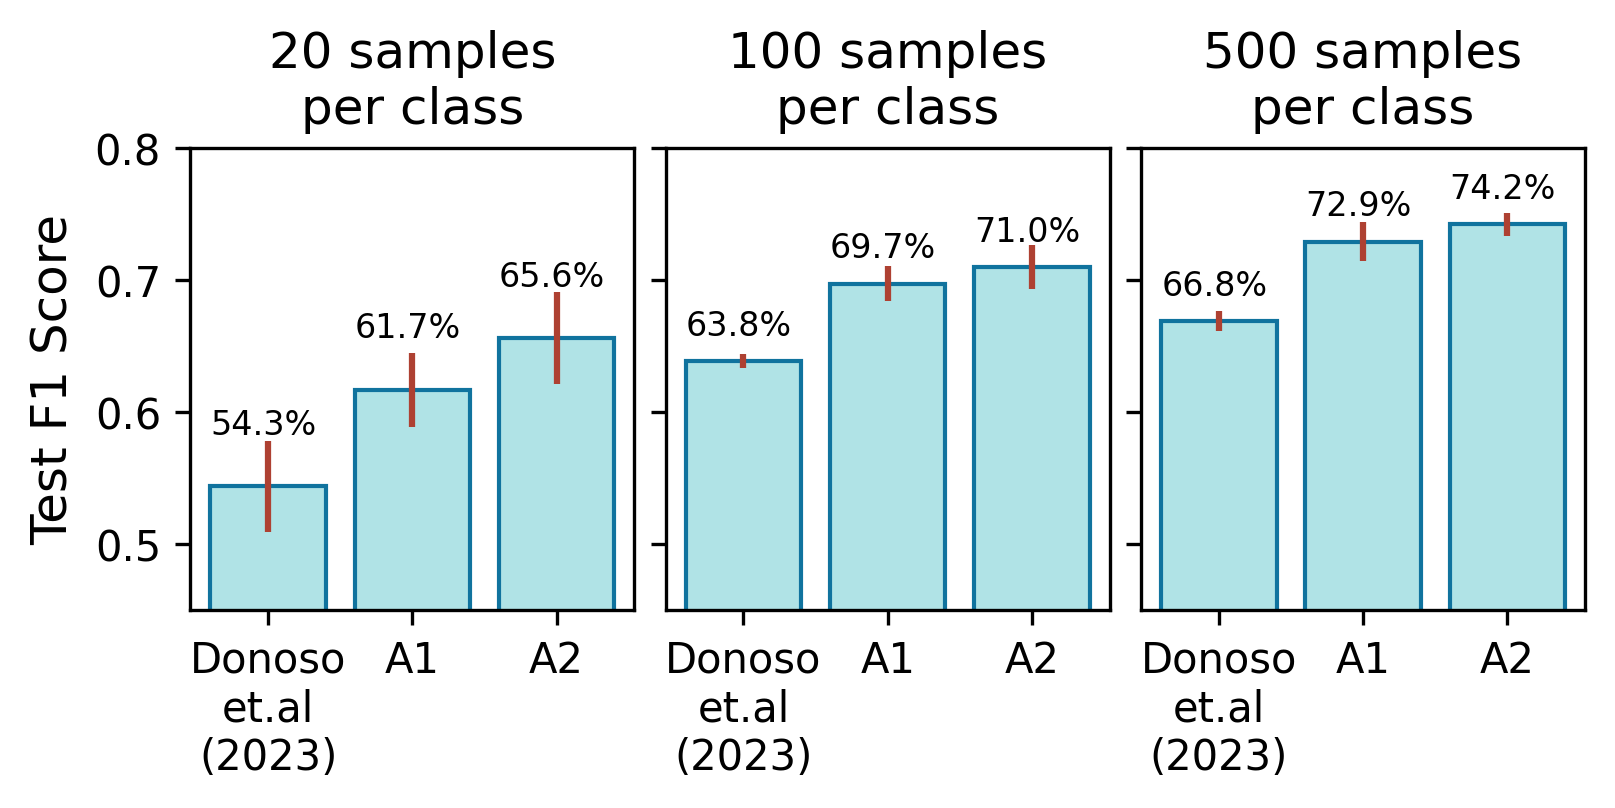

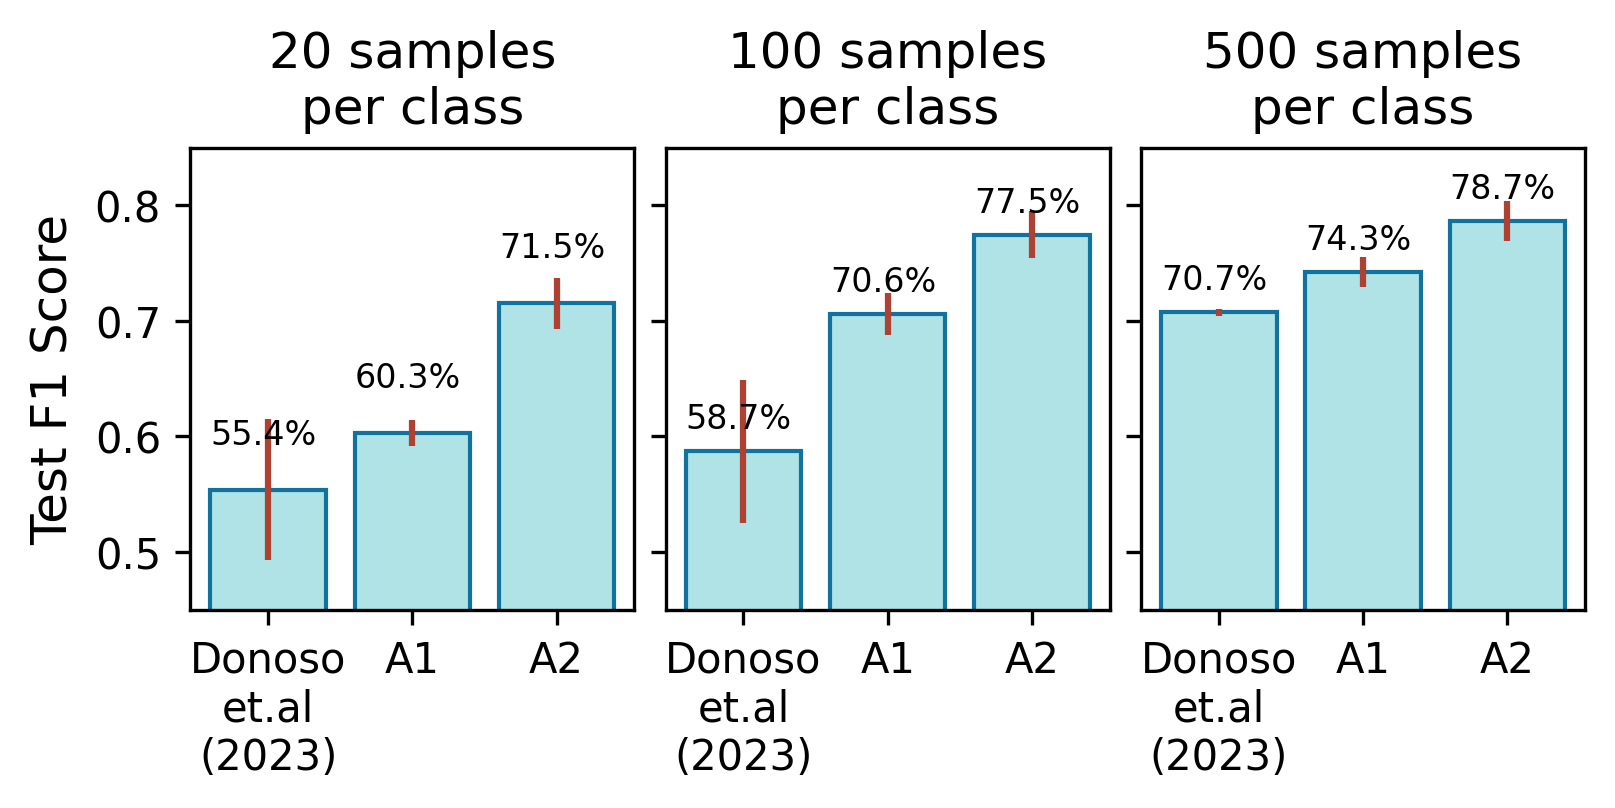

In [87]:
for group0, df0 in test_metrics.groupby('data'):
    fig, axes = plt.subplots(1, 3, figsize=plotconfig[TAG]['figsize'], sharey=True, dpi=300, gridspec_kw={'wspace': 0.07})
    for k, (group1, df1) in enumerate(df0.groupby('spc')):

        xticks = range(df1['label'].shape[0])
        xv = list(xticks)
        yv = df1['mean'].values
        ye = df1['std'].values
        
        axes[k].bar(xv, yv, yerr=ye, color='#B0E3E6', ecolor='#AE4132', edgecolor='#10739E')
        axes[k].set_xticks(xticks)
        axes[k].set_xticklabels(df1['label'].values, rotation=0, fontsize=10)
        axes[k].set_title('{} samples\nper class'.format(group1))
        axes[k].set_ylim(plotconfig[TAG]['ylim'][group0])
        
        for i, value in enumerate(df1['mean']):
            if k == 0:
                axes[k].text(i-0.4, value+0.04, '{:.1f}%'.format(value*100) ,fontsize=8, rotation=0)
            else:
                axes[k].text(i-0.4, value+0.02, '{:.1f}%'.format(value*100) ,fontsize=8, rotation=0)
    axes[0].set_ylabel('Test F1 Score', fontsize=12)
    # axes[0].legend(ncols=2)
    
    if group0 == 'alcock': title = 'Classification on MACHO'
    if group0 == 'atlas': title = 'Classification on ATLAS'
#     fig.text(0.5, 1.05, title, ha='center', fontsize=12)
#     fig.text(plotconfig[TAG]['xlabel']['x'], 
#              plotconfig[TAG]['xlabel']['y'], 
#              plotconfig[TAG]['xlabel']['label'], ha='center', fontsize=12)      
    
    os.makedirs('./presentation/figures/classification/{}'.format(TAG), exist_ok=True)
    fig.savefig('./presentation/figures/classification/{}/{}.pdf'.format(TAG, group0), format='pdf', bbox_inches='tight')  
    fig.savefig('./presentation/figures/classification/{}/{}.png'.format(TAG, group0), format='png', bbox_inches='tight')  

In [18]:
if TAG == 'ckpt':
    train_metrics, val_metrics = tensorboard_logs('./presentation/results/ckpt/epoch_0/pretraining/')
    
    
    for sset in ['alcock', 'atlas']:
        fig, ax = plt.subplots(1, 3, figsize=(15, 3), sharey=True, gridspec_kw={'wspace': 0.3}, dpi=300)
        for i, SPC in enumerate([20, 100, 500]):
            test_selected = test_metrics[(test_metrics['spc'] == SPC) & (test_metrics['data'] == sset)][['ckpt', 'mean', 'std']]
            x = test_selected['ckpt'].astype(int)
            y = test_selected['mean']
            yerr = test_selected['std']
            
            
            ax[i].plot(val_metrics['step'], val_metrics['loss'], color='k')
            ax[i].set_ylabel('Validation RMSE')
            
            ax2 = ax[i].twinx()
            ax2.errorbar(x[:-1], y[:-1], yerr=yerr[:-1], marker='.', color='darkred')
            ax2.axhline(y=y.iloc[-1], color='darkgreen', linestyle='--', label='Best (epoch {})'.format(x.iloc[-1]))
            ax2.set_ylabel('F1 Score (3-fold mean)')
            ax2.set_xticks(x.iloc[:-1])
            ax[i].set_xticklabels(x.iloc[:-1], rotation=45)

            if sset == 'alcock':
                plt.title('MACHO \n{} samples per class'.format(SPC))
            if sset == 'atlas':
                plt.title('ATLAS \n{} samples per class'.format(SPC))
                
            lines1, labels1 = ax[i].get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax[i].legend(lines1 + lines2, labels1 + labels2, loc='center right')
        fig.savefig('./presentation/figures/clf_ckpt_{}.pdf'.format(sset), format='pdf', bbox_inches='tight')
    plt.show()